# 引入包

In [1]:
import  torch
import  torch.nn as nn
import  torch.nn.functional as F
import  numpy
import random
from torchvision import transforms
from PIL import Image
import os
from torch.utils.data import  Dataset,random_split,DataLoader
from numpy import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

# 超参数

In [2]:
batch_size = 158
lr = 0.0001
epoch_num = 200 
num_work = 2

# 加载数据集合

In [3]:
class MyDataset(Dataset):
    def __init__(self, data_path, transform=None, train=True):

        self.data_path = data_path
        self.transform = transform
        self.label_folder = os.listdir(self.data_path)
        self.file = []
        for str in self.label_folder:
            st = os.path.join(self.data_path, str)
            my = os.listdir(st)
            random.shuffle(my)
            t = my[int(len(my) * 0.7):]
            if train:
                t = my[:int(len(my) * 0.7)]

            for index in t:
                self.file.append(os.path.join(st, index))

    def __len__(self):
        return len(self.file)

    def __getitem__(self, idx):

        # 读取图像和标签文件
        image = Image.open(self.file[idx])
        label = os.path.split(os.path.dirname(self.file[idx]))[-1]
        # 数据转换
        if self.transform:
            image = self.transform(image)

        return image, torch.eye(3)[self.label_folder.index(label)]


transform = transforms.Compose([
    transforms.Resize((100, 100)),

    transforms.ToTensor(),
])

# 创建自定义数据集
TrainDataset = MyDataset(data_path=r'/kaggle/input/expersion03/train',
                         transform=transform
                         , train=True)
TestDataset = MyDataset(data_path=r'/kaggle/input/expersion03/train',
                        transform=transform
                        , train=False)
print(TrainDataset.__len__(), TestDataset.__len__())

948 409


# 定义网络

In [4]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, downsample=None,model=True):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.conv1_1=None
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = None
        if model:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, bias=False)
            self.conv1_1= nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, padding=0, bias=False)
            self.downsample= nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1)
        self.model = model
        
        

    def forward(self, x):
        identity = x
        if self.model:
            identity = self.conv1_1(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            out = self.downsample(out)
#         print(out.size(),identity.size())
        out = identity+ out
        out = self.relu(out)
        return out

# 定义ResNet主体结构
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3,64,3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu=nn.ReLU()
        self.layer1 = BasicBlock(64,64,1,None,False)
        self.layer2 = BasicBlock(64,64,1,None,False)
        
        self.dropout1 = nn.Dropout2d(0.5)
        
        self.layer3 = BasicBlock(64,128,2,None,True)
        self.layer4 = BasicBlock(128,128,1,None,False)

        self.dropout2 = nn.Dropout2d(0.5)
        
        self.layer5 = BasicBlock(128,256,2,None,True)
        self.layer6 = BasicBlock(256,256,1,None,False)

        self.dropout3 = nn.Dropout2d(0.5)
        
        self.layer7 = BasicBlock(256,512,2,None,True)
        self.layer8 = BasicBlock(512,512,1,None,False)
        self.dropout4 = nn.Dropout2d(0.5)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 , 3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        
#         x = self.dropout1(x)
        
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.dropout2(x)
        x = self.layer5(x)
        x = self.layer6(x)
        
#         x = self.dropout3(x)
        
        x = self.layer7(x)
        x = self.layer8(x)
        
#         x = self.dropout4(x)
        
        x = self.avgpool(x)
        x = self.fc(x.view(batch_size,-1))

        return x


# 训练与超参数

In [5]:
import time
net = ResNet().to(device)
train_loss=[]
train_acc=[]
test_loss=[]
test_acc=[]
opt = torch.optim.Adam(net.parameters(), lr=lr)
train_loader = DataLoader(TrainDataset, batch_size=batch_size, shuffle=True,num_workers=num_work)
test_loader = DataLoader(TestDataset, batch_size=batch_size, shuffle=True,num_workers=num_work)
loss = nn.CrossEntropyLoss()
start_time = time.time()
for epoch in range(epoch_num):
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    for x, y in train_loader:
        y_hat = net(x.to(device))
        l = loss(y_hat.view(-1), y.view(-1).to(device))
        acc = 0
        y_index = torch.argmax(y_hat, dim=1)
        Y = torch.argmax(y, dim=1)
        for i in range(len(y_index)):
            if y_index[i] == Y[i]:
                acc += 1
        train_acc_list.append(acc/len(y_index))
        opt.zero_grad()
        l.backward()
        train_loss_list.append(l.item())
        opt.step()

    for x, y in test_loader:
        net.eval()
        if(x.size()[0]<batch_size):
            continue
        y_hat = net(x.to(device))
        net.train()
        l = loss(y_hat.view(-1), y.view(-1).to(device))
        # print(l)
        acc = 0
        y_index = torch.argmax(y_hat, dim=1)
        Y = torch.argmax(y, dim=1)
        for i in range(len(y_index)):
            if y_index[i] == Y[i]:
                acc += 1
        test_acc_list.append(acc/len(y_index))
        test_loss_list.append(l.item())
        # print("done")
    train_loss_mean = numpy.mean(train_loss_list)
    train_acc_mean=numpy.mean(train_acc_list)
    train_loss.append(train_loss_mean)
    train_acc.append(train_acc_mean)
    test_loss_mean=numpy.mean(test_loss_list)
    test_acc_mean=numpy.mean(test_acc_list)

    test_loss.append(test_loss_mean)
    test_acc.append(test_acc_mean)
    print("epoch:",epoch+1,
          "\n",
          "train_loss:",train_loss_mean,'train_acc',train_acc_mean,
           "\n",
          "test_loss:", test_loss_mean, 'test_acc',test_acc_mean
          )
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

epoch: 1 
 train_loss: 952.6833801269531 train_acc 0.5421940928270043 
 test_loss: 980.5965270996094 test_acc 0.25632911392405067
epoch: 2 
 train_loss: 961.4887491861979 train_acc 0.47573839662447265 
 test_loss: 956.0748596191406 test_acc 0.5664556962025317
epoch: 3 
 train_loss: 954.5726521809896 train_acc 0.5748945147679325 
 test_loss: 950.8892517089844 test_acc 0.5886075949367089
epoch: 4 
 train_loss: 952.8457336425781 train_acc 0.5748945147679324 
 test_loss: 953.8544311523438 test_acc 0.5664556962025316
epoch: 5 
 train_loss: 951.804433186849 train_acc 0.5748945147679324 
 test_loss: 955.2638244628906 test_acc 0.5569620253164558
epoch: 6 
 train_loss: 951.551279703776 train_acc 0.5748945147679324 
 test_loss: 951.9586791992188 test_acc 0.569620253164557
epoch: 7 
 train_loss: 950.7333984375 train_acc 0.5748945147679325 
 test_loss: 952.9198303222656 test_acc 0.5506329113924051
epoch: 8 
 train_loss: 948.3313191731771 train_acc 0.5748945147679324 
 test_loss: 949.364013671875 t

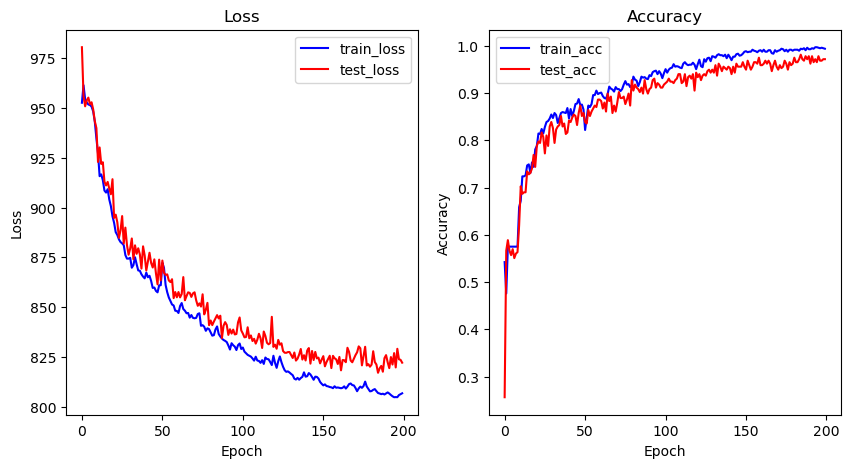

In [6]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

plt.plot(train_loss, 'b-',label="train_loss")
plt.plot(test_loss, 'r-' ,label="test_loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, 'b-',label="train_acc")
plt.plot(test_acc, 'r-' ,label="test_acc")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()